In [1]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
df = pd.read_csv('salary_prediction_data.csv')

df['Education'] = df['Education'].map({'PhD': 3, 'Master': 2, 'Bachelor': 1, 'High School': 0})
df['Location'] = df['Location'].map({'Urban': 2, 'Suburban': 1, 'Rural': 0})
df['Job_Title'] = df['Job_Title'].map({'Manager': 3, 'Director': 2, 'Analyst': 1, 'Engineer': 0})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0}) 

print(df.head())

   Education  Experience  Location  Job_Title  Age  Gender         Salary
0          0           8         2          3   63       1   84620.053665
1          3          11         1          2   59       1  142591.255894
2          1          28         1          3   61       0   97800.255404
3          0          29         0          2   45       1   96834.671282
4          3          25         2          1   26       0  132157.786175


In [3]:
X = df[['Education','Experience','Location','Job_Title','Age','Gender']].values
Y = df[['Salary']].values

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [4]:
X_train = X_train.astype(float)
Y_train = Y_train.astype(float)
X_val = X_val.astype(float)
Y_val = Y_val.astype(float)

In [17]:
KRG_model = KRG(theta0=[1e-2], corr='squar_exp')
KRG_model.set_training_values(X_train, Y_train)
KRG_model.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 800
   
___________________________________________________________________________
   
 Training
   
   Training ...


/opt/homebrew/lib/python3.11/site-packages/smt/surrogate_models/krg_based.py:462: UserWarning: Warning: multiple x input features have the same value (at least same row twice).
  warnings.warn(


   Training - done. Time (sec): 22.4702201


In [18]:
#RBF_model = RBF()
#RBF_model.set_training_values(X_train, Y_train)
#RBF_model.train()

In [19]:
#   1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(6,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

#   2. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#   3. Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

#    4. Train the model
history = model.fit(
    X_train,
    Y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

#   5. Evaluate the model
Y_predicted_ANN = model.predict(X_val)
print("MSE, for ANN", mean_squared_error(Y_val, Y_predicted_ANN))


Epoch 1/500
25/25 [==============================] - 0s 3ms/step - loss: 11881634816.0000 - val_loss: 12168154112.0000
Epoch 2/500
25/25 [==============================] - 0s 1ms/step - loss: 11859305472.0000 - val_loss: 12095477760.0000
Epoch 3/500
25/25 [==============================] - 0s 1ms/step - loss: 11579002880.0000 - val_loss: 11383447552.0000
Epoch 4/500
25/25 [==============================] - 0s 1ms/step - loss: 9765444608.0000 - val_loss: 7873082368.0000
Epoch 5/500
25/25 [==============================] - 0s 1ms/step - loss: 4309097984.0000 - val_loss: 1180934400.0000
Epoch 6/500
25/25 [==============================] - 0s 1ms/step - loss: 686353216.0000 - val_loss: 516669184.0000
Epoch 7/500
25/25 [==============================] - 0s 1ms/step - loss: 543063808.0000 - val_loss: 496725920.0000
Epoch 8/500
25/25 [==============================] - 0s 1ms/step - loss: 482416224.0000 - val_loss: 437548288.0000
Epoch 9/500
25/25 [==============================] - 0s 1ms/step

In [20]:
X_new = np.array([['2','3','2','0','24','1']])
Y_predicted_KRG = KRG_model.predict_values(X_val)
print("MSE, for KRG:", mean_squared_error(Y_val, Y_predicted_KRG))
#Y_predicted_RBF = RBF_model.predict_values(X_val)
#print("MSE, for RBF:", mean_squared_error(Y_val, Y_predicted_RBF))


___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 200
   
   Predicting ...
   Predicting - done. Time (sec):  0.1647561
   
   Prediction time/pt. (sec) :  0.0008238
   
MSE, for KRG: 145070027.0158551


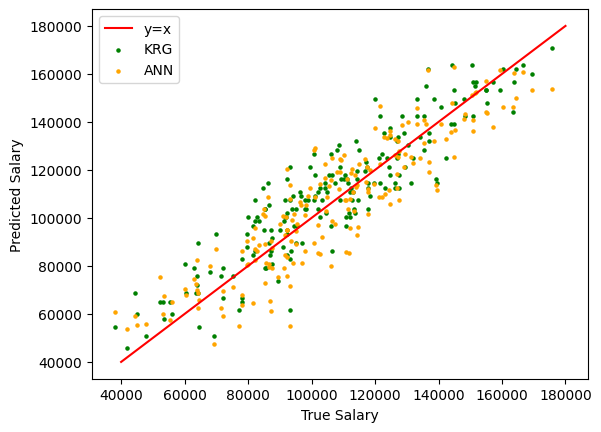

In [21]:
plt.plot([40000, 180000], [40000, 180000], label='y=x', color='red')

plt.scatter(Y_val, Y_predicted_KRG, s=5, label='KRG', color='green')
plt.scatter(Y_val, Y_predicted_ANN, s=5, label='ANN', color='orange')
#plt.scatter(Y_val, Y_predicted_RBF, s=5, label='RBF', color='blue')
plt.xlabel('True Salary')
plt.ylabel('Predicted Salary')
plt.legend()




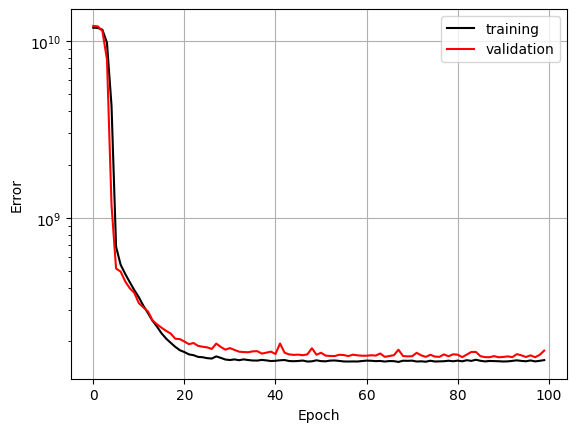

In [22]:
plt.semilogy(history.history['loss'],'k',label='training')
plt.semilogy(history.history['val_loss'],'r',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()